In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
from keras.datasets import mnist

<h1> Preprocessing</h1>

### Load images into a (n ,x ,y ,3) array

In [11]:
from PIL import Image
import os

def load_images_from_folder(folder, target_size=(32, 32)):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).resize(target_size)
        if img is not None:
            images.append(np.array(img))
    return np.array(images)

folder_path = os.path.join(os.getcwd(), 'images')
images = load_images_from_folder(folder_path)

# Ensure the images are in the shape (n, x, y, 3)
print(f'{images.shape = }')

images.shape = (25, 32, 32, 3)


Flattening image with -1,3 gives the pixels in rows for r g b and the each pixel below.
Flattening image with images.reshape[0] , -1 25 picture with 3072 colors.

### Flaten image array

In [12]:
flattendImages = images.reshape(-1, 3)
# flattendImages = images.reshape(images.shape[0], -1)

print(flattendImages.shape)

(25600, 3)


```markdown
### Covariance Calculation
```

In [13]:
def calculateCovariance(matrix: np.ndarray) -> np.ndarray:
    return np.cov(matrix, rowvar=False, bias=True)
print(calculateCovariance(flattendImages))

[[5132.29747178 4147.81532516 4202.54758892]
 [4147.81532516 4995.49374676 5056.44228032]
 [4202.54758892 5056.44228032 6585.40058181]]


In [14]:
def calculateCovarianceWithDot(X):
    meanX = np.mean(X, axis = 0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance
print(calculateCovarianceWithDot(flattendImages))

[[5132.29747178 4147.81532516 4202.54758892]
 [4147.81532516 4995.49374676 5056.44228032]
 [4202.54758892 5056.44228032 6585.40058181]]


```markdown
### Plot data and covarince
```

In [15]:
import seaborn as sns

def plotDataAndCov(data):
    ACov = calculateCovariance(data)
    print ('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)

    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)

    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)

    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

<h1> Mean normalization</h1>

In [16]:
def center(x):
    return x - np.mean(x, axis=0)

### Standardization


In [17]:
def standardize(x):
    return center(x) / np.std(x, axis=0)

<h1> Whitening</h1>

### Zero centering

In [18]:
def zeroCentered(x):
    return center(x)

### Decorrelate

In [19]:
def decorrelate(x):
    cov = calculateCovariance(x)
    eigvals, eigvecs = np.linalg.eig(cov)
    decorrelated = x.dot(eigvecs)
    return decorrelated, eigvals

### Rescale the data

In [20]:
def whiten(x):
    decorrelated, eigvals = decorrelate(x)
    whitened = decorrelated / np.sqrt(eigvals + 1e-5)
    return whitened

Covariance matrix:
 [[5132.29747178 4147.81532516 4202.54758892]
 [4147.81532516 4995.49374676 5056.44228032]
 [4202.54758892 5056.44228032 6585.40058181]]


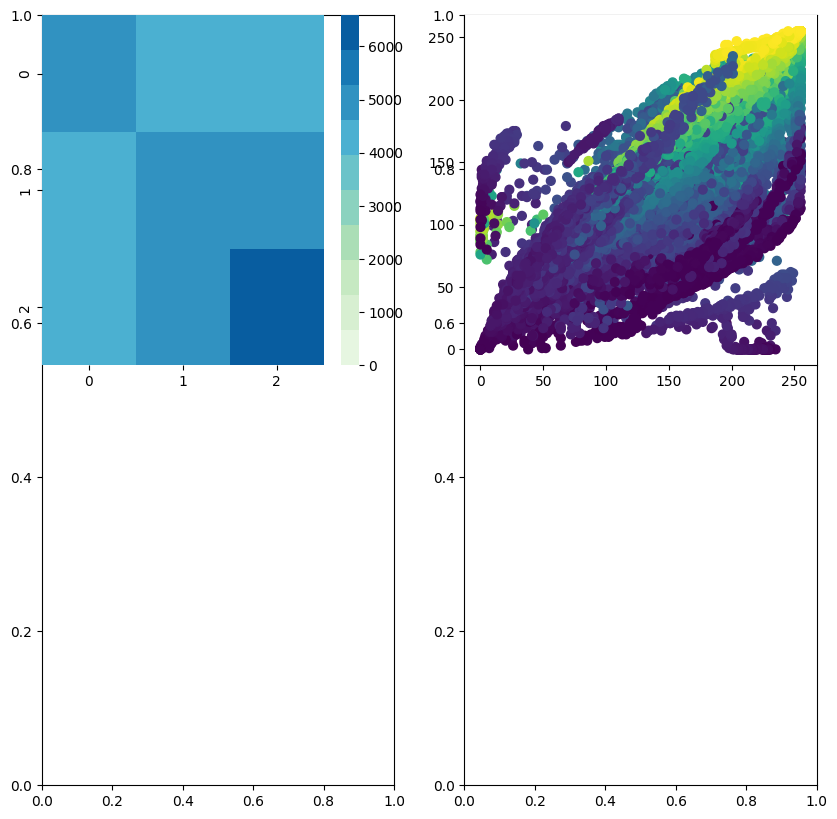

Covariance matrix:
 [[ 9.99999999e-01 -1.88737914e-16 -1.02140518e-15]
 [-1.88737914e-16  9.99999994e-01  3.72923914e-15]
 [-1.02140518e-15  3.72923914e-15  9.99999981e-01]]


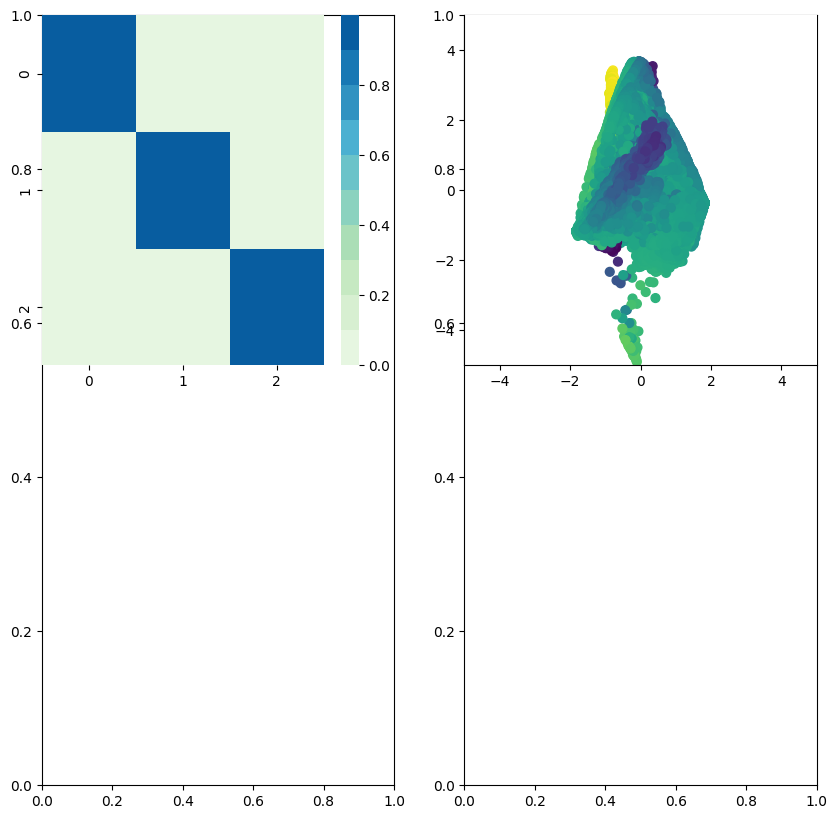

In [21]:
# Testing
plotDataAndCov(flattendImages)
plt.show()
plt.close()

centered = center(flattendImages)
CWhitned = whiten(centered)

plotDataAndCov(CWhitned)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()


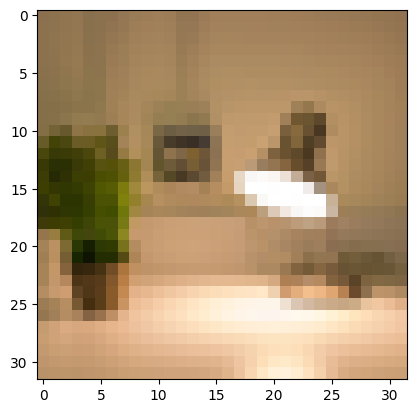

In [65]:
def plotSamples(imagesArray, index):
    imageToPlot = imagesArray[index,:,:,:]
    plt.imshow(imageToPlot)
    plt.show()
    plt.close()

plotSamples(images, 12)


<h1> Mean subtraction per pixel</h1>

In [23]:
x = load_images_from_folder(folder_path)

x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])

xNorm = x / 255
xNorm = x - x.mean(axis=0)
cov = calculateCovariance(xNorm)

print(cov.shape)

U,S,V = np.linalg.svd(cov)

print(U.shape, S.shape)

(3072, 3072)
(3072, 3072) (3072,)


In [24]:
def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32,32,3))
    plt.show()
    plt.close()

### Rescale the images

min: 0.0
max: 1.0


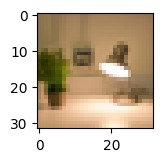

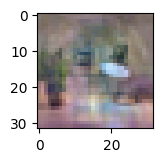

In [68]:
epsilon = 0.1
x_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(xNorm.T).T
x_ZCA_rescaled = (x_ZCA - x_ZCA.min()) / (x_ZCA.max() - x_ZCA.min())

print("min:", x_ZCA_rescaled.min())
print("max:", x_ZCA_rescaled.max())

plotImage(x[12, :])
plotImage(x_ZCA_rescaled[12, :])




<h1>Task 1.2 Import somebody's else dataset into Jupyter enivorment</h1>

In [26]:
def loadDataIntoArray(position):
    data = np.load('vecs.npy', allow_pickle=True).item()
    
    if position not in data:
        raise ValueError(f"Position {position} not found in the data.")
    
    embeddings = []
    labels = []
    
    digitsDic = data[position]
    for digit, embedding in digitsDic.items():
        embeddings.extend(embedding)
        labels.extend([int(digit)])

    embeddingsArray = np.array(embeddings)
    labelsArray = np.array(labels)
    
    return embeddingsArray, labelsArray

In [27]:
def shuffleData(position):
    
    embeddings, labels = loadDataIntoArray(position)

    permutation = np.random.permutation(len(labels))
    shuffledEmbeddings = embeddings[permutation]
    shuffledLabels = labels[permutation]

    return shuffledEmbeddings, shuffledLabels


### Running and showing the result.

In [28]:
position = "2_pos"
embeddingsArray, labelsArray = loadDataIntoArray(position)
shuffledEmbeddings, shuffledLabels = shuffleData(position)

print("Embeddings before permutation:", embeddingsArray)
print("Labels before permutation:", labelsArray)

print("Embeddings shape after permutation:", shuffledEmbeddings)
print("Labels shape after permutation:", shuffledLabels)


Embeddings before permutation: [[-0.       -0.       60.908226 ... -0.       -0.       -0.      ]
 [-0.        0.       -0.       ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 ...
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]]
Labels before permutation: [0 1 2 3 4 5 6 7 8 9]
Embeddings shape after permutation: [[-0.0000000e+00 -0.0000000e+00  6.0908226e+01 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00  0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -2.1966856e-28 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 ...
 [-0.0000000e+00 -0.0000000e+00  2.7431396e+01 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000

<h1> Nearst Neighbour classifier</h1>

In [29]:
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()

In [30]:
Xtr.shape

(60000, 28, 28)

In [31]:
28*28

784

In [32]:
#Traing phase
num_sample=500
Tr_set=Xtr[:num_sample,:,:]
Ltr_set=Ltr[:num_sample]

# Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2])
Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2]).astype('int')

Tr_set.shape

(500, 784)

### 3 fold cross-validation

In [33]:
def predict(X):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):
        #L1 manhattan distance  accuracy=0.2649
        # distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1)
        
        #L2 euclidean distance accuaracy= 0.19
        distances=np.sqrt(np.sum(np.square(Tr_set-X[i,:]),axis=1))
        
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [34]:
def predict1NN(X, k, norm='L2'):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):
        #L1 manhattan distance  accuracy=0.2649
        if norm=='L1':
            distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1)
         #L2 euclidean distance accuaracy= 0.19
        elif norm=='L2':
            distances=np.sqrt(np.sum(np.square(Tr_set-X[i,:]),axis=1))
        else:
            raise ValueError('Norm not supported')
         
        #Find k smallest distances
        nearestIndices= np.argsort(distances)[:k]
        
        #Voting
        kNearestLabels=Ltr_set[nearestIndices]

        Lpred[i] = np.bincount(kNearestLabels).argmax()
    return Lpred

In [35]:
def predictKNN(Tr_set, Ltr_set, X, k):
    num_test = X.shape[0]
    Lpred = np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):

        distances = np.sqrt(np.sum((Tr_set - X[i, :]) ** 2, axis=1))
        
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = Ltr_set[nearest_indices]
        
        Lpred[i] = np.bincount(nearest_labels).argmax()

        tiedLabels = np.where(np.bincount(nearest_labels) == np.bincount(nearest_labels).max())[0]
        if len(tiedLabels) == 1:
            Lpred[i] = tiedLabels[0]
        else:
            # If there is a tie, select the label with the smallest distance
            tiedLabelsIndices = [index for index in nearest_indices if Ltr_set[index] in tiedLabels]
            closestIndex = tiedLabelsIndices[0]
            Lpred[i] = Ltr_set[closestIndex]
    
    return Lpred

In [36]:
def crossValidateKnn(Tr_set, Ltr_set, k_values):
    numSamples=Tr_set.shape[0]
    foldSize=numSamples // 3
    accuraciesPerK={}

    foldX = [Tr_set[i*foldSize:(i+1)*foldSize] for i in range(3)]
    foldY = [Ltr_set[i*foldSize:(i+1)*foldSize] for i in range(3)]

    for k in k_values:
        accuracies=[]
        for i in range(3):

            xVal= foldX[i]
            yVal= foldY[i]

            xTrain=np.concatenate(foldX[:i]+foldX[i+1:])
            yTrain=np.concatenate(foldY[:i]+foldY[i+1:])

            yPred=predictKNN(xTrain,yTrain,xVal,k)
            
            accuracy = np.mean(yPred == yVal)
            accuracies.append(accuracy)

        accuraciesPerK[k]=np.mean(accuracies)

    bestK = max(accuraciesPerK, key=accuraciesPerK.get)
    return bestK, accuraciesPerK

In [37]:
Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=predict(Test_images)
print("Accuracy before:", np.mean(Labels_predicted==L_test))

#KNN 
kValues = [1,3,5,7,9]
bestK, accuraciesPerK = crossValidateKnn(Tr_set, Ltr_set, kValues)
print("Best K:", bestK)
print("Accuracies per K:", accuraciesPerK)

#Predict with optimal K
Labels_predictedKNN=predictKNN(Tr_set,Ltr_set,Test_images,bestK)
print("Accuracy with best k:", np.mean(Labels_predictedKNN==L_test))


Accuracy before: 0.8294
Best K: 3
Accuracies per K: {1: np.float64(0.8313253012048193), 3: np.float64(0.8353413654618475), 5: np.float64(0.821285140562249), 7: np.float64(0.8012048192771085), 9: np.float64(0.8052208835341365)}
Accuracy with best k: 0.8189


<h1> SVM </h1>

### Train SVM with linear, polynomial and RBF kernels

Aims to find desicion boundary, this can be done usin N-dimensinal space where decision boundary is N - 1.  

### Loading and splitting the data

In [38]:
# Load iris dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

iris = load_iris()

X = iris.data
y = iris.target
featuresLabel = iris.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape)



(120, 4) (30, 4)


### Train SVM models with different kernels

In [39]:
def plotDecisionBoundary(ax, X, y, model, title, feature_names):
    # Define the mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plotting decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(title)

In [40]:
def plotConfusionMatrix(ax, cm, kernel, approach, i, j):
    ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_title(f'Confusion Matrix: {kernel} kernel - {approach} - Features {i} vs {j}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks(np.arange(len(iris.target_names)))
    ax.set_yticks(np.arange(len(iris.target_names)))
    ax.set_xticklabels(iris.target_names, rotation=45)
    ax.set_yticklabels(iris.target_names)
    
    # Annotate cells
    for k in range(len(cm)):
        for l in range(len(cm)):
            ax.text(l, k, cm[k, l], ha='center', va='center', color='black')


In [98]:
def trainSVM(kernels, approaches, featureDimension):
    results = []
    plot_data = []

    for kernel in kernels:
        for approach in approaches:
            
            # Train SVM model
            svc = SVC(kernel=kernel, decision_function_shape=approach)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            supportVectors = svc.support_vectors_
            
            for i, j in featureDimension:
                XPair = X_train[:, [i-1, j-1]]
                svc.fit(XPair, y_train)
                featureNames = [featuresLabel[i-1], featuresLabel[j-1]]

                plot_data.append({
                    'XPair': XPair,
                    'y_train': y_train,
                    'y_test': y_test,
                    'svc': svc,
                    'kernel': kernel,
                    'approach': approach,
                    'i': i,
                    'j': j,
                    'featureNames': featureNames,
                }) 

            # Save results
            results.append({
                'kernel': kernel,
                'approach': approach,
                'features': (i, j),
                'accuracy': accuracy,
                'f1': f1,
                'support_vectors': supportVectors
            })

    return results, plot_data

In [101]:
def plot_svm_results(XPair, y_train, y_test, svc, kernel, approach, i, j, featureNames):
    """Function to plot the decision boundary and confusion matrix"""
    # Plot decision boundary
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the decision boundary
    plotDecisionBoundary(axs[1], XPair, y_train, svc, f'{kernel} kernel - {approach} - features {i} vs {j}', featureNames)

    X_test_pair = X_test[:, [i-1, j-1]]
    y_pred = svc.predict(X_test_pair)
    # Plot confusion matrix
    confusionMatrix = confusion_matrix(y_test, y_pred)
    plotConfusionMatrix(axs[0], confusionMatrix, kernel, approach, i, j)

    plt.tight_layout()
    plt.show()

Best Kernel Type: linear, Approach: ovo, Accuracy: 1.0, F1 Score: 1.0
results = [{'kernel': 'linear', 'approach': 'ovo', 'features': (3, 4), 'accuracy': 1.0, 'f1': np.float64(1.0), 'support_vectors': array([[5.1, 3.8, 1.9, 0.4],
       [4.5, 2.3, 1.3, 0.3],
       [4.8, 3.4, 1.9, 0.2],
       [6.2, 2.2, 4.5, 1.5],
       [5.9, 3.2, 4.8, 1.8],
       [6.1, 2.9, 4.7, 1.4],
       [6.9, 3.1, 4.9, 1.5],
       [6.3, 2.5, 4.9, 1.5],
       [6. , 2.9, 4.5, 1.5],
       [6. , 2.7, 5.1, 1.6],
       [5.1, 2.5, 3. , 1.1],
       [6.8, 2.8, 4.8, 1.4],
       [6.7, 3. , 5. , 1.7],
       [5.4, 3. , 4.5, 1.5],
       [6.3, 2.8, 5.1, 1.5],
       [6.3, 2.7, 4.9, 1.8],
       [6.2, 2.8, 4.8, 1.8],
       [6.3, 2.5, 5. , 1.9],
       [7.2, 3. , 5.8, 1.6],
       [6. , 2.2, 5. , 1.5],
       [4.9, 2.5, 4.5, 1.7],
       [6.1, 3. , 4.9, 1.8],
       [5.6, 2.8, 4.9, 2. ],
       [6.9, 3.1, 5.1, 2.3],
       [6.5, 3.2, 5.1, 2. ]])}, {'kernel': 'linear', 'approach': 'ovr', 'features': (3, 4), 'accuracy': 

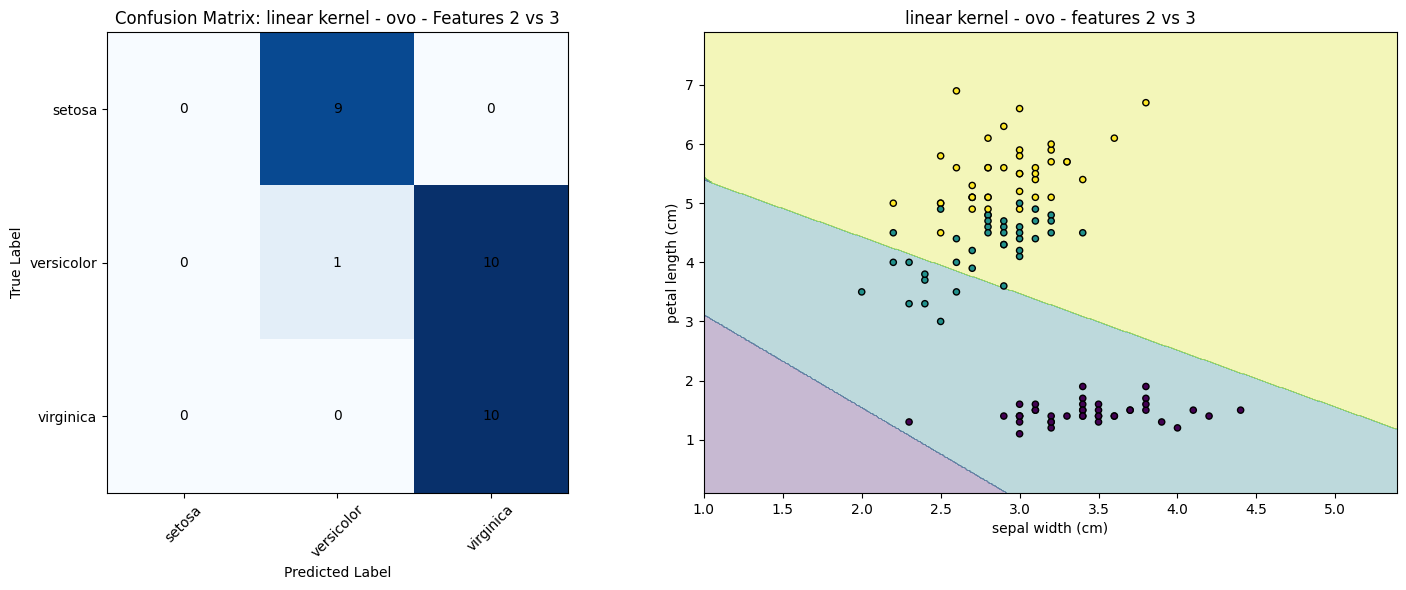

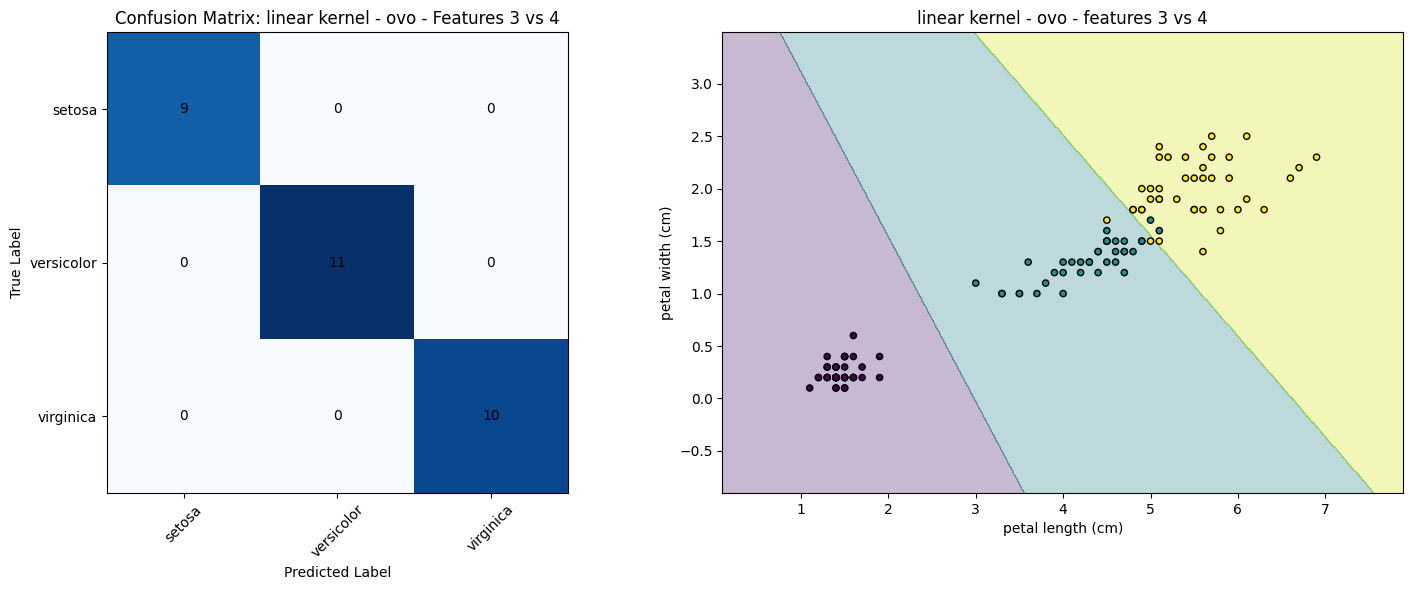

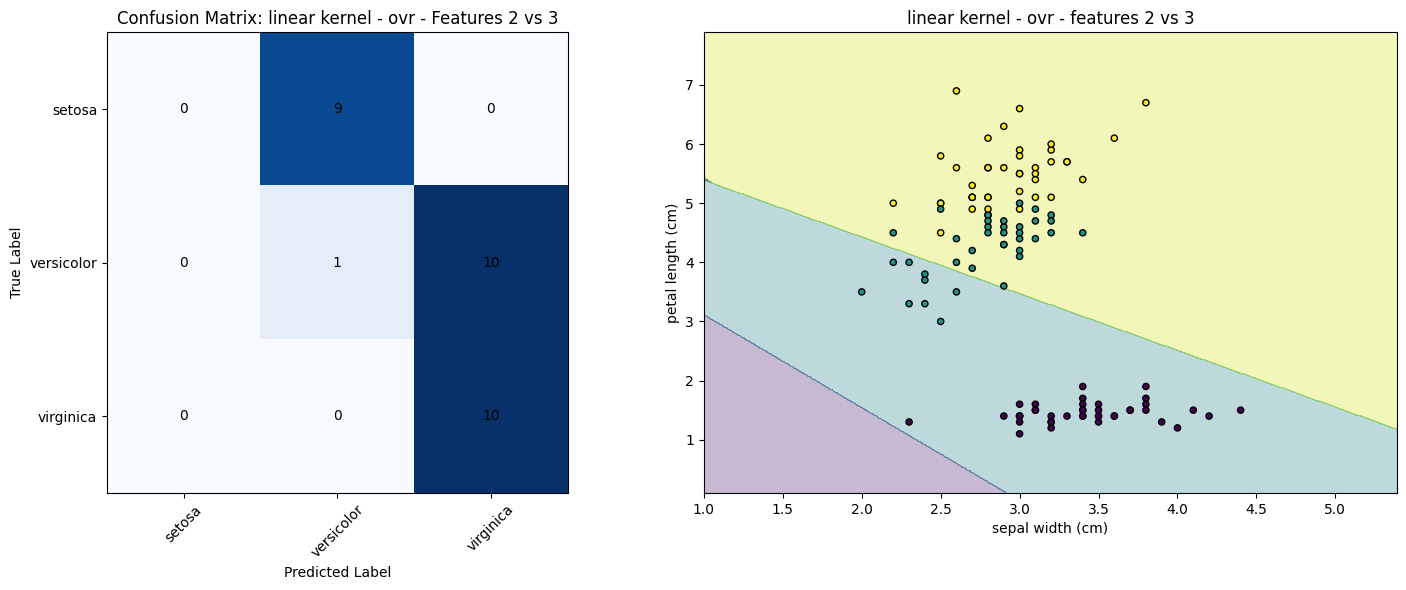

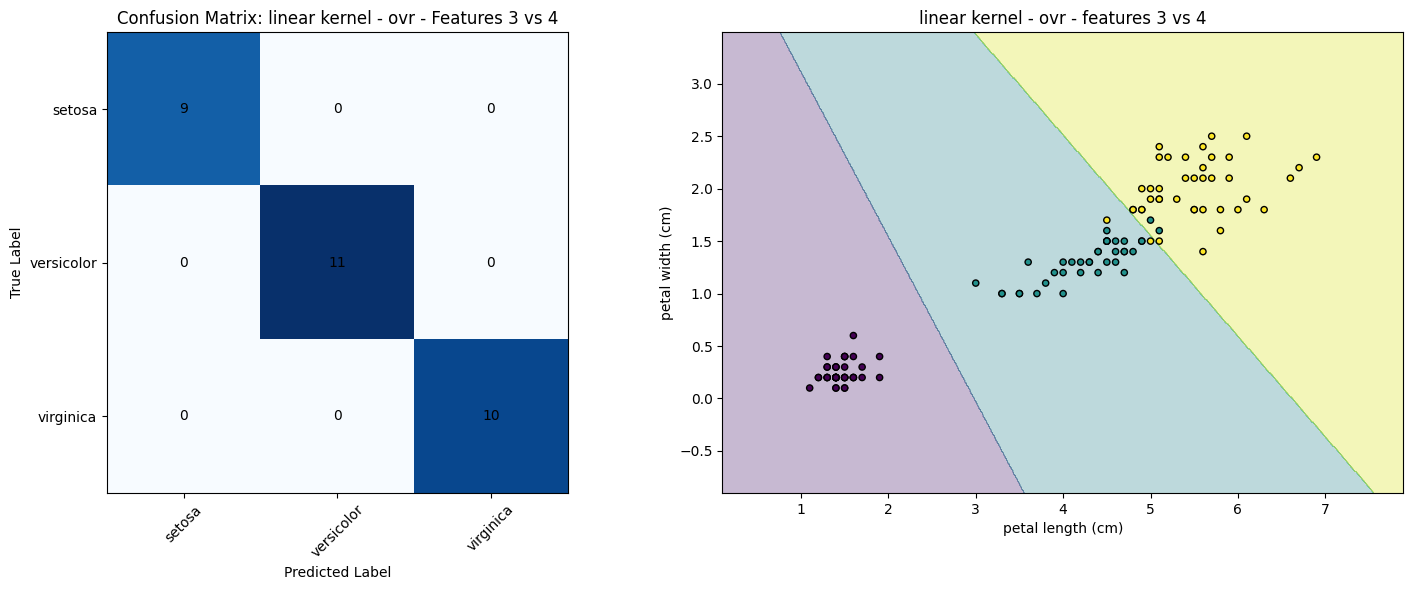

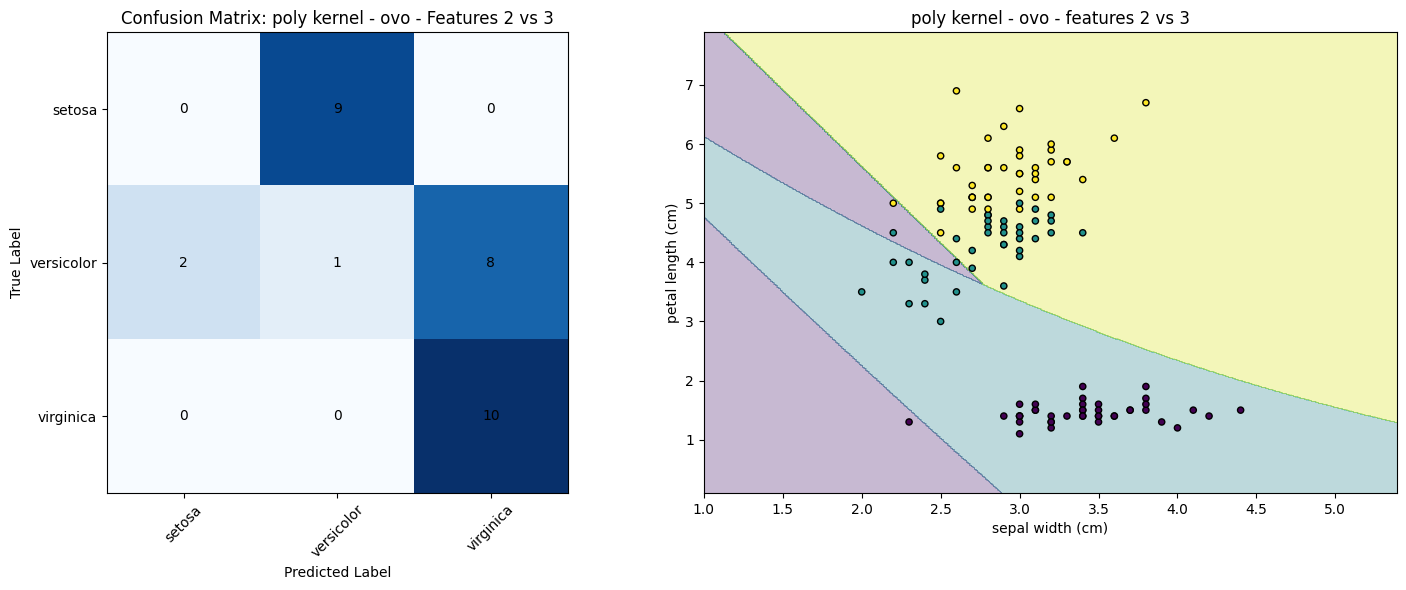

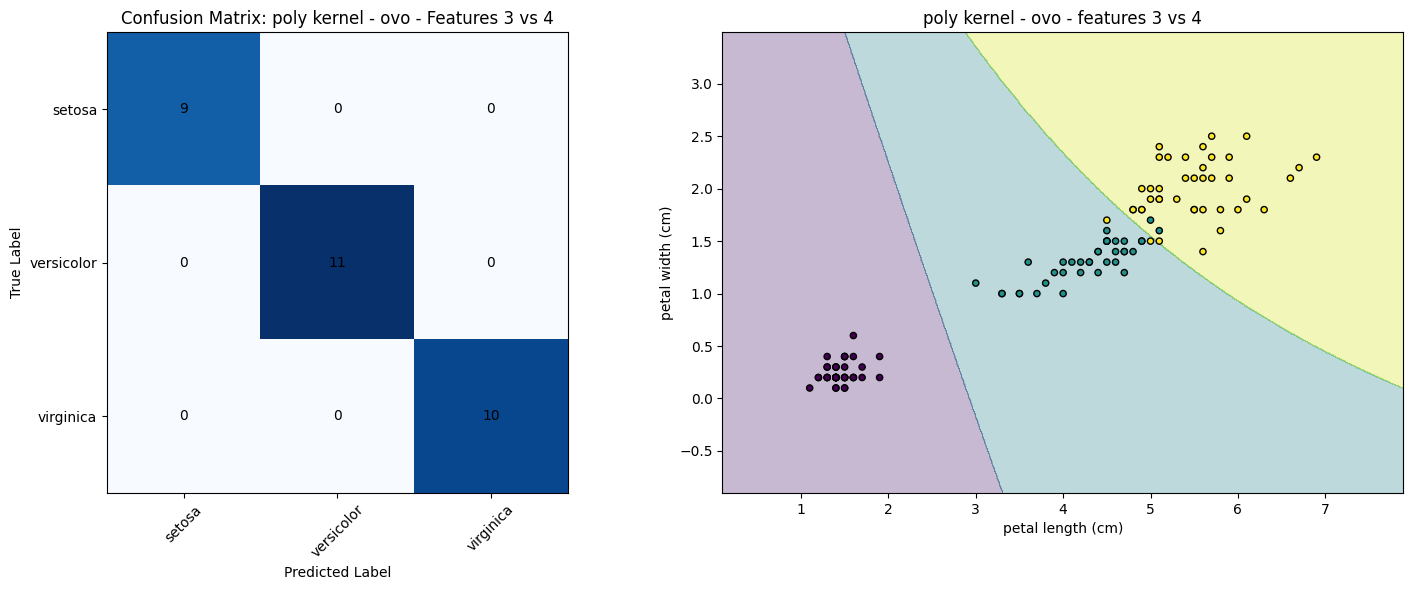

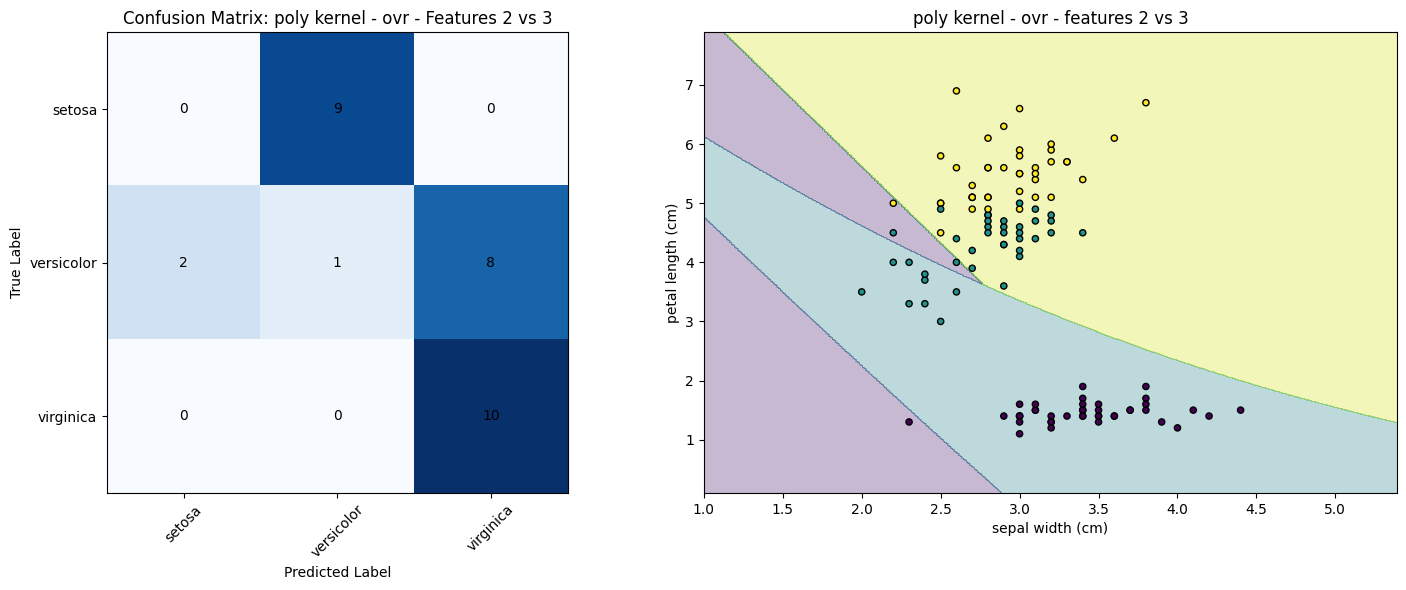

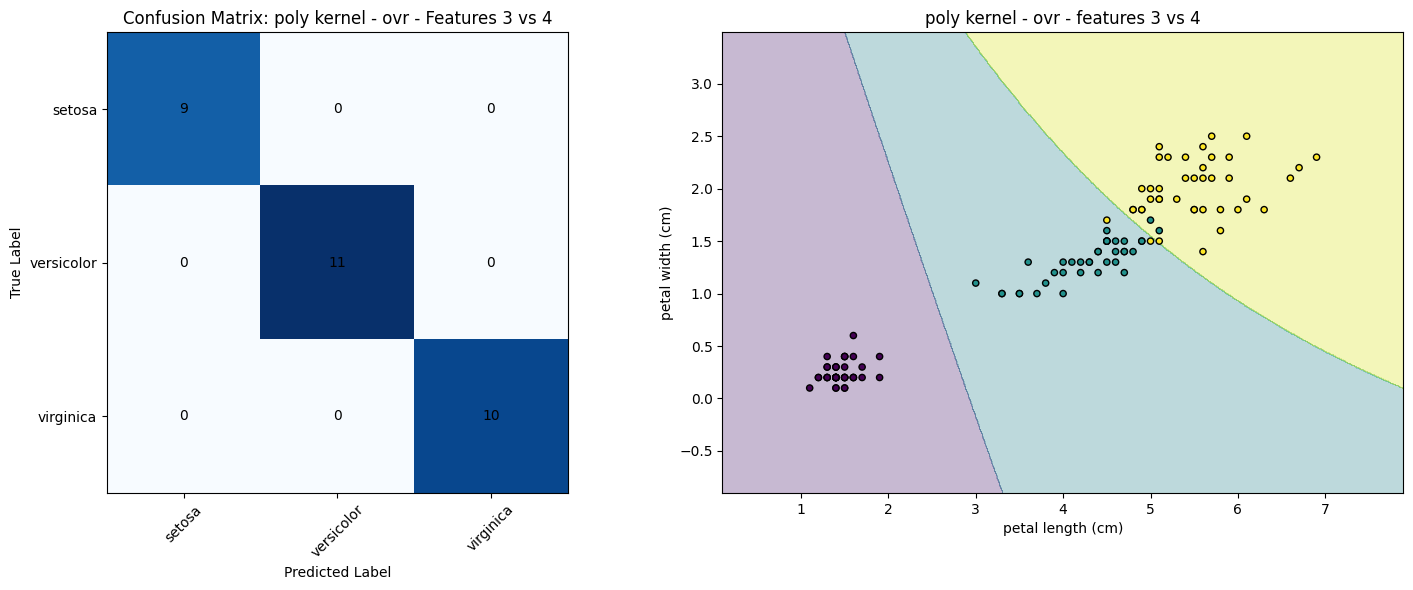

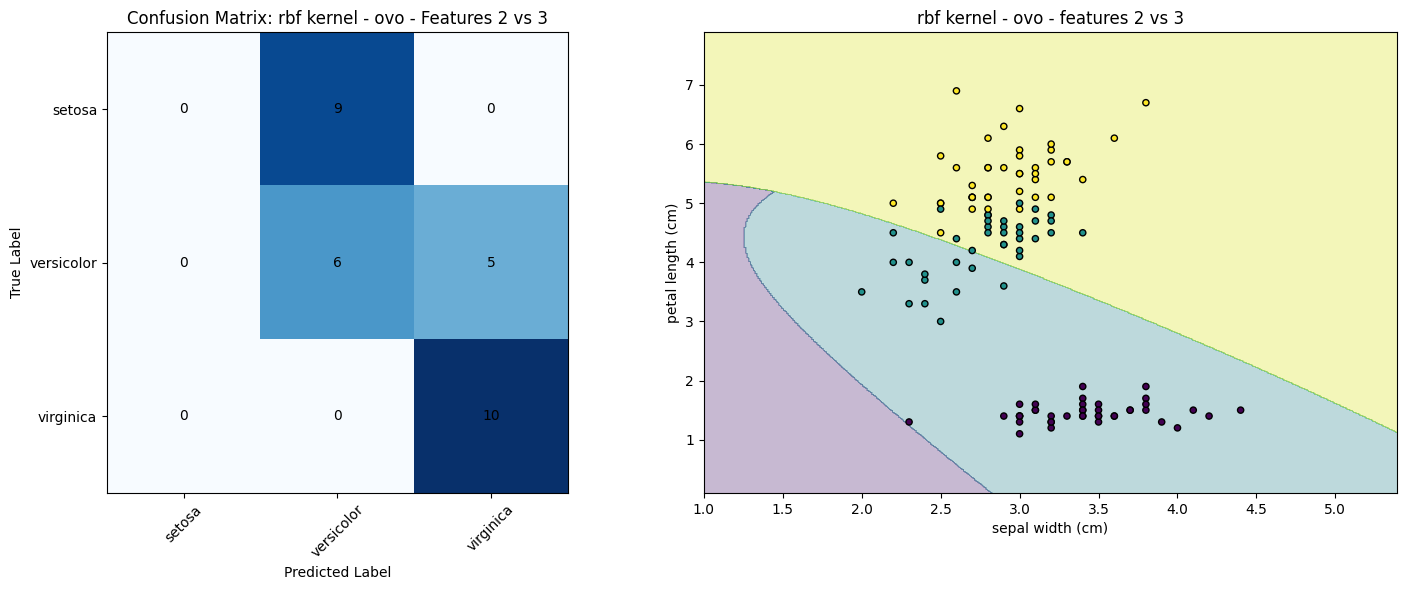

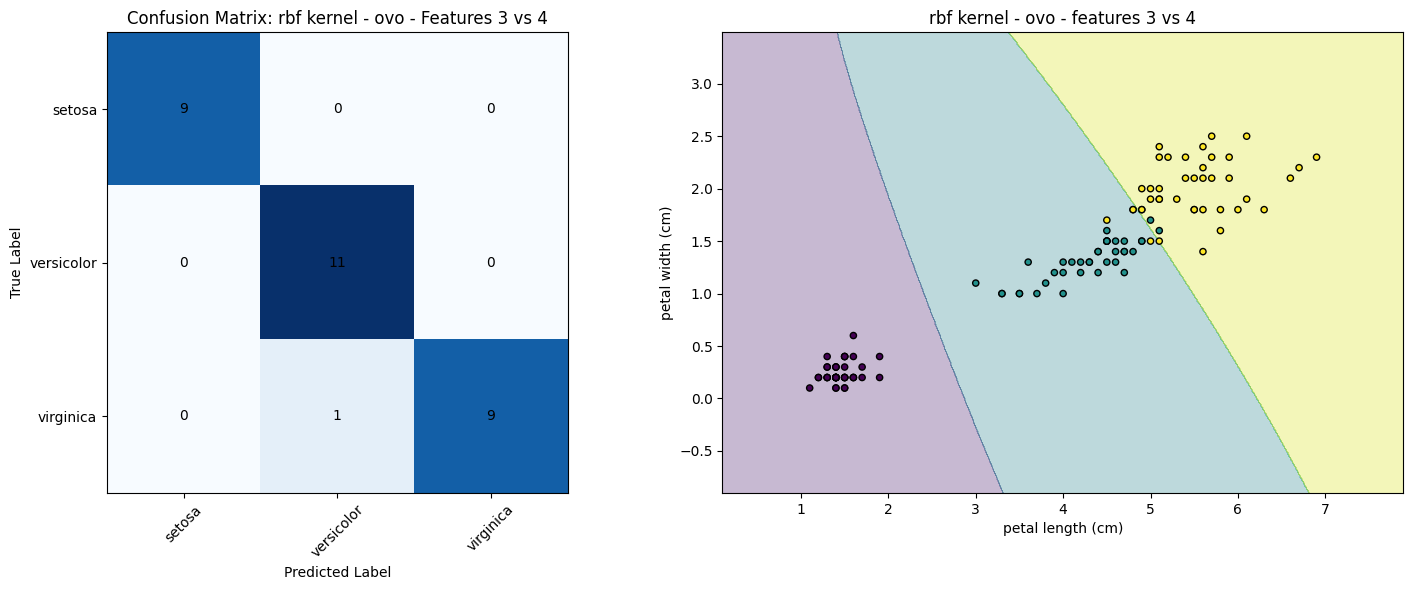

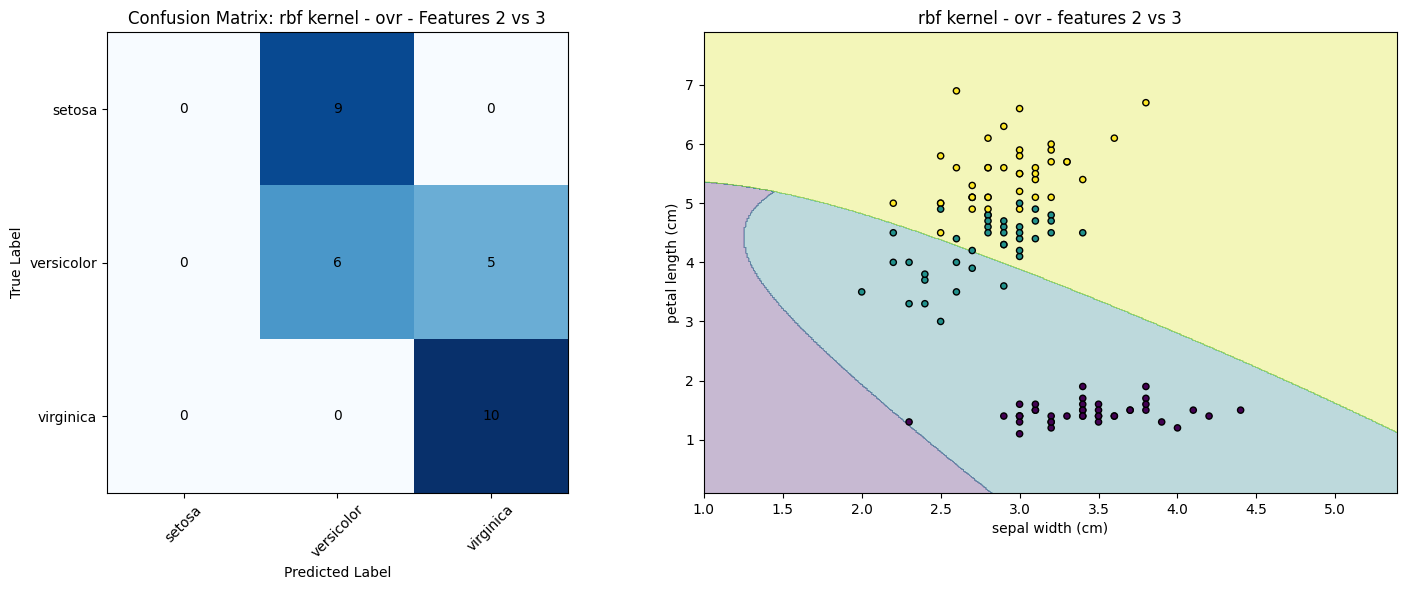

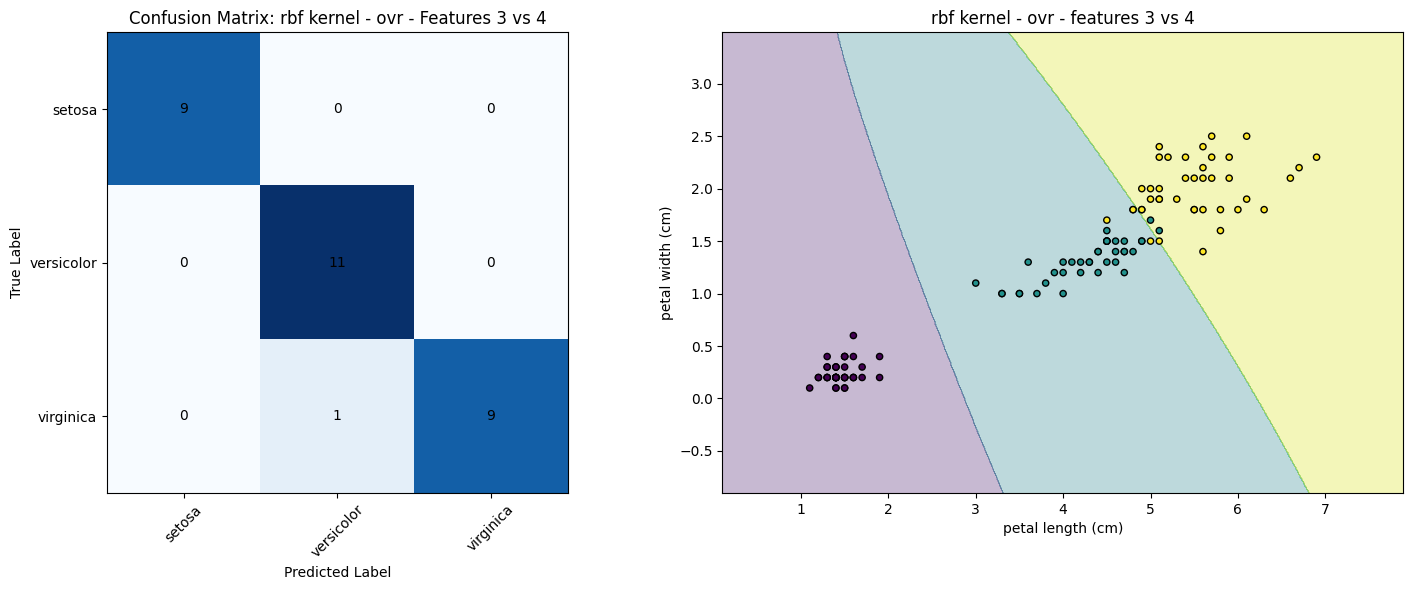

In [105]:
kernels = ['linear', 'poly', 'rbf']
approaches = ['ovo', 'ovr']
featureDimension = [(2, 3), (3, 4)]


results, plot_data = trainSVM(kernels, approaches, featureDimension)


best_result = max(results, key=lambda x: (x['accuracy'], x['f1']))
print(f"Best Kernel Type: {best_result['kernel']}, Approach: {best_result['approach']}, Accuracy: {best_result['accuracy']}, F1 Score: {best_result['f1']}")
print(f'{results = }')

for data in plot_data:
    plot_svm_results(
        data['XPair'], 
        data['y_train'], 
        data['y_test'], 
        data['svc'], 
        data['kernel'], 
        data['approach'], 
        data['i'], 
        data['j'], 
        data['featureNames']
    )
